# LArTPC Reconstruction Pipeline

This notebook allows you to create 3D points/tracks and run the full LArTPC reconstruction pipeline on them. It will automatically project the 3D volume to 2D planes, then reconstruct the original 3D points from those projections.

## Setup and Imports

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from time import time
import math
from IPython.display import display

# Add the parent directory to the path to import the package
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("__file__")))))

from lartpc_reconstruction import (
    LArTPCReconstructor,
    Line3D,
    visualize_volume,
    visualize_projections,
    visualize_lines_and_intersections,
    visualize_original_vs_reconstructed
)

## Define Your 3D Points

You can define your 3D points in several ways:
1. As a list of points
2. As a set of tracks (lines between points)
3. Using parametric curves

In [2]:
# Define volume parameters
volume_shape = (128, 128, 128)  # Volume size in voxels
voxel_size = 1.0                # Size of each voxel in mm

# Choose device (use CUDA if available)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Define reconstruction parameters
tolerance = 1.5        # Tolerance for line intersection (in mm)
merge_tolerance = 2.0  # Tolerance for merging nearby intersections (in mm)
debug = True           # Whether to print detailed debugging information
fast_merge = True      # Whether to use fast merging algorithm

Using device: cuda


### Option 1: Define Individual Points

Define a list of 3D points. Each point is an (x, y, z) coordinate.

In [3]:
# Define points as a list of (x, y, z) coordinates
# Example: A few random points
individual_points = [
    (20, 30, 40),
    (40, 50, 60),
    (60, 70, 80),
    (80, 90, 100)
]

# Convert to a numpy array
points_array = np.array(individual_points)

### Option 2: Define Tracks (Lines Between Points)

Define tracks as a list of start and end points. Each track is a line from start to end.

In [4]:
# Define tracks as a list of (start_point, end_point) tuples
# Example: A diagonal line and a horizontal line
tracks = [
    ((20, 20, 20), (100, 100, 100)),  # Diagonal line
    ((20, 50, 50), (100, 50, 50))     # Horizontal line
]

# You can add more tracks here

### Option 3: Create Parametric Curves

Define more complex shapes using parametric equations.

In [5]:
# Example: Create a helix
def create_helix(start=(40, 40, 20), radius=20, height=80, turns=3, num_points=100):
    t = np.linspace(0, turns * 2 * np.pi, num_points)
    x = start[0] + radius * np.cos(t)
    y = start[1] + radius * np.sin(t)
    z = start[2] + height * t / (turns * 2 * np.pi)
    return np.column_stack((x, y, z))

# Example: Create a sine wave in 3D space
def create_sine_wave(start=(20, 60, 60), length=80, amplitude=20, periods=2, num_points=100):
    t = np.linspace(0, 1, num_points)
    x = start[0] + length * t
    y = start[1] + amplitude * np.sin(periods * 2 * np.pi * t)
    z = start[2] + amplitude * np.cos(periods * 2 * np.pi * t)
    return np.column_stack((x, y, z))

# Create a helix
helix_points = create_helix()

# Create a sine wave
sine_points = create_sine_wave()

## Choose Which Points to Use

Select which set of points you want to use for reconstruction. Uncomment the one you want to use.

In [6]:
# Choose which points to use (uncomment one option)

# Option 1: Use individual points
# input_points = points_array

# Option 2: Use tracks
# Flatten the tracks into a list of start and end points
track_points = []
for start, end in tracks:
    # Create multiple points along the line to ensure continuity
    start_point = np.array(start)
    end_point = np.array(end)
    line_vec = end_point - start_point
    line_length = np.linalg.norm(line_vec)
    num_points = int(np.ceil(line_length)) + 1  # One point per mm
    t_values = np.linspace(0, 1, num_points)
    line_points = start_point + np.outer(t_values, line_vec)
    track_points.append(line_points)
track_points = np.vstack(track_points)
input_points = track_points

# Option 3: Use parametric curves (helix or sine wave)
# input_points = helix_points
# input_points = sine_points

# Option 4: Combine multiple sets
# input_points = np.vstack([track_points, helix_points])

print(f"Using {len(input_points)} input points")

Using 221 input points


## Create Volume from Points

This function creates a sparse volume representation from the input points.

In [9]:
def create_volume_from_points(points, volume_shape, radius=0.0, device='cuda'):
    """
    Create a 3D volume from a set of points.
    Each point is expanded to a sphere with the given radius.
    
    Args:
        points (numpy.ndarray): Array of shape (N, 3) containing point coordinates
        volume_shape (tuple): Shape of the volume (x, y, z)
        radius (float): Radius of each point in voxels
        device (str): Device to use ('cuda' or 'cpu')
        
    Returns:
        tuple: (sparse_volume, dense_volume, original_points)
               - sparse_volume is a tuple of (coords, values, shape)
               - dense_volume is a torch.Tensor
               - original_points is the input points in the correct format
    """
    # Convert points to tensor
    points_tensor = torch.tensor(points, dtype=torch.float32, device=device)
    
    # Ensure points are within volume bounds
    points_tensor = torch.clamp(
        points_tensor,
        min=torch.zeros(3, device=device),
        max=torch.tensor(volume_shape, device=device) - 1
    )
    
    # Round to get voxel coordinates
    voxel_coords = torch.round(points_tensor).long()
    
    # If radius > 0, expand each point to a sphere
    if radius > 0:
        # Create offsets for points in a sphere
        r = int(math.ceil(radius))
        offsets = []
        for dx in range(-r, r+1):
            for dy in range(-r, r+1):
                for dz in range(-r, r+1):
                    dist = math.sqrt(dx**2 + dy**2 + dz**2)
                    if dist <= radius:
                        offsets.append((dx, dy, dz, dist))
        
        # Convert offsets to tensor
        offset_coords = torch.tensor([(o[0], o[1], o[2]) for o in offsets], device=device)
        
        # For each point, add all offsets
        expanded_coords = []
        expanded_values = []
        
        for point in voxel_coords:
            # Add offsets to the point
            sphere_coords = point.unsqueeze(0) + offset_coords
            
            # Calculate values based on distance from center
            distances = torch.tensor([o[3] for o in offsets], device=device)
            values = torch.exp(-(distances/radius)**2 / 2)
            
            # Ensure coordinates are within bounds
            valid_mask = (
                (sphere_coords[:, 0] >= 0) & (sphere_coords[:, 0] < volume_shape[0]) &
                (sphere_coords[:, 1] >= 0) & (sphere_coords[:, 1] < volume_shape[1]) &
                (sphere_coords[:, 2] >= 0) & (sphere_coords[:, 2] < volume_shape[2])
            )
            
            expanded_coords.append(sphere_coords[valid_mask])
            expanded_values.append(values[valid_mask])
        
        # Combine all expanded coordinates
        all_coords = torch.cat(expanded_coords, dim=0)
        all_values = torch.cat(expanded_values, dim=0)
    else:
        # Just use the original coordinates with value 1.0
        all_coords = voxel_coords
        all_values = torch.ones(len(voxel_coords), device=device)
    
    # Create a unique identifier for each voxel
    voxel_ids = (
        all_coords[:, 0] * volume_shape[1] * volume_shape[2] +
        all_coords[:, 1] * volume_shape[2] +
        all_coords[:, 2]
    )
    
    # Find unique voxels and take maximum value for each
    unique_ids, inverse_indices = torch.unique(voxel_ids, return_inverse=True)
    
    # Create output arrays
    unique_coords = torch.zeros((len(unique_ids), 3), dtype=torch.long, device=device)
    unique_values = torch.zeros(len(unique_ids), device=device)
    
    # For each unique ID, find the maximum value
    for i, id in enumerate(unique_ids):
        mask = (voxel_ids == id)
        unique_coords[i] = all_coords[mask][0]  # Take the first matching coordinate
        unique_values[i] = torch.max(all_values[mask])  # Take the maximum value
    
    # Create the sparse representation
    sparse_volume = (unique_coords, unique_values, volume_shape)
    
    # Create the dense representation
    dense_volume = torch.zeros(volume_shape, device=device)
    dense_volume[unique_coords[:, 0], unique_coords[:, 1], unique_coords[:, 2]] = unique_values
    
    return sparse_volume, dense_volume, points

## Generate Volume from Input Points

In [10]:
# Create the volume from input points
print("\n1. Creating volume from points...")
start_time = time()

# Use a small radius to make the points more visible
point_radius = 1.5
sparse_volume, dense_volume, original_points = create_volume_from_points(
    input_points, volume_shape, radius=point_radius, device=device
)

coords, values, shape = sparse_volume
print(f"Created volume with {coords.shape[0]} non-zero voxels in {time() - start_time:.2f} seconds")


1. Creating volume from points...
Created volume with 1771 non-zero voxels in 0.39 seconds


## Visualize the Original Volume

Text(0.5, 0.92, 'Original Volume')

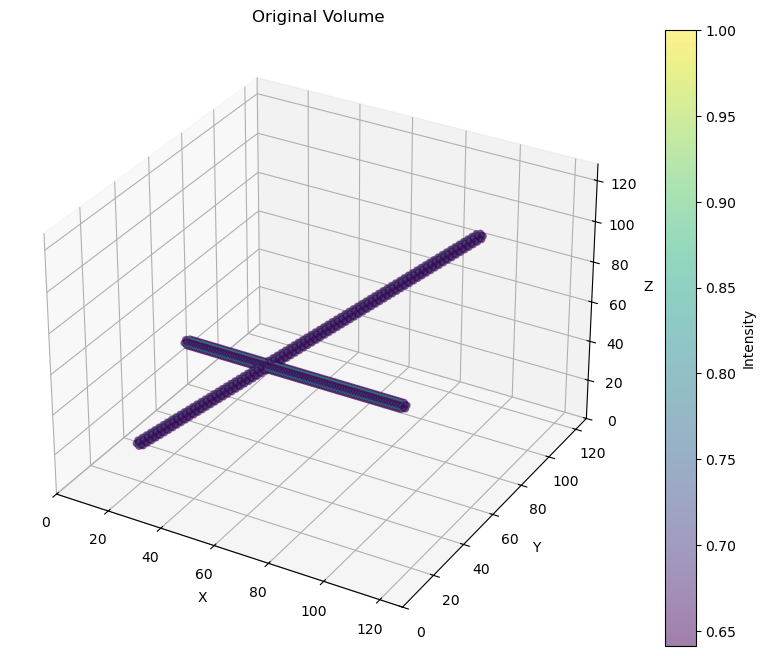

In [12]:
# Visualize the volume
fig = visualize_volume(dense_volume)
plt.title("Original Volume")

## Initialize the Reconstructor

In [13]:
# Create the reconstructor
print("\n2. Creating reconstructor...")
reconstructor = LArTPCReconstructor(
    volume_shape=volume_shape,
    tolerance=tolerance,
    merge_tolerance=merge_tolerance,
    device=device,
    debug=debug
)


2. Creating reconstructor...


## Project the Volume to 2D Planes

In [14]:
# Project the volume to 2D
print("\n3. Projecting volume to 2D...")
start_time = time()

# Use sparse representation for projection
projections = reconstructor.project_volume(sparse_volume)

print(f"Projected volume in {time() - start_time:.2f} seconds")


3. Projecting volume to 2D...
Projecting sparse volume with 1771 non-zero voxels...
Projecting sparse volume from 1771 non-zero voxels...
  Projecting to plane 0 (theta=0.00)...
    Projection shape: torch.Size([128, 102])
    Non-zero elements: 643
    Completed in 0.13 seconds
  Projecting to plane 1 (theta=1.57)...
    Projection shape: torch.Size([128, 109])
    Non-zero elements: 643
    Completed in 0.13 seconds
  Projecting to plane 2 (theta=1.05)...
    Projection shape: torch.Size([128, 105])
    Non-zero elements: 597
    Completed in 0.13 seconds
All sparse projections completed in 0.39 seconds
Projection to 3 planes completed in 0.39 seconds
Projected volume in 0.39 seconds


## Visualize the 2D Projections

These are the projections that would be measured by the wire planes in a LArTPC detector.

In [ ]:
# Visualize the projections
fig = visualize_projections(projections)
plt.suptitle("2D Projections")
display(fig)

## Reconstruct 3D Points from 2D Projections

This is the core inverse problem: reconstructing 3D points from their 2D projections.

In [ ]:
# Reconstruct 3D points from 2D projections
print("\n4. Reconstructing 3D points from projections...")
start_time = time()
reconstructed_points = reconstructor.reconstruct_from_projections(
    projections, threshold=0.1, fast_merge=fast_merge
)
print(f"Reconstructed {reconstructed_points.size(0)} points in {time() - start_time:.2f} seconds")

## Visualize Original vs Reconstructed Points

In [ ]:
# Visualize original vs reconstructed points
if len(reconstructed_points) > 0:
    fig = visualize_original_vs_reconstructed(
        original_points,
        reconstructed_points.cpu().numpy(),
        volume_shape=volume_shape
    )
    plt.title("Original vs Reconstructed Points")
    display(fig)
else:
    print("No points were reconstructed.")

## Reconstruction Quality Metrics

Let's compute some metrics to evaluate the quality of the reconstruction.

In [ ]:
# Calculate reconstruction quality metrics
if len(reconstructed_points) > 0:
    # Convert reconstructed points to numpy
    reconstructed_np = reconstructed_points.cpu().numpy()
    
    # 1. Calculate minimum distances from each reconstructed point to original points
    from scipy.spatial.distance import cdist
    distances = cdist(reconstructed_np, original_points)
    min_distances = np.min(distances, axis=1)
    
    print("\nReconstruction Quality Statistics:")
    print(f"Mean distance to original points: {np.mean(min_distances):.3f} voxels")
    print(f"Max distance to original points: {np.max(min_distances):.3f} voxels")
    print(f"Min distance to original points: {np.min(min_distances):.3f} voxels")
    print(f"Standard deviation of distances: {np.std(min_distances):.3f} voxels")
    
    # 2. Calculate coverage (percentage of original points that have a reconstructed point nearby)
    threshold = tolerance * 1.5  # Consider a point covered if a reconstructed point is within this distance
    min_distances_to_reconstructed = np.min(cdist(original_points, reconstructed_np), axis=1)
    covered_points = min_distances_to_reconstructed <= threshold
    coverage = np.sum(covered_points) / len(original_points)
    
    print(f"Coverage of original points: {coverage * 100:.1f}%")
    print(f"Number of original points: {len(original_points)}")
    print(f"Number of reconstructed points: {len(reconstructed_np)}")
    
    # 3. Calculate histogram of distances
    plt.figure(figsize=(10, 6))
    plt.hist(min_distances, bins=20, alpha=0.7)
    plt.axvline(x=tolerance, color='r', linestyle='dashed', linewidth=2, label=f'Tolerance ({tolerance} voxels)')
    plt.xlabel('Distance to Nearest Original Point (voxels)')
    plt.ylabel('Count')
    plt.title('Distribution of Distances from Reconstructed to Original Points')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Reconstruct Full 3D Volume

Now let's reconstruct the full 3D volume from the projections.

In [ ]:
# Reconstruct 3D volume from projections
print("\n5. Reconstructing 3D volume from projections...")
start_time = time()

# Use sparse reconstruction
reconstructed_sparse_volume = reconstructor.reconstruct_sparse_volume(
    projections, threshold=0.1, voxel_size=1.0, fast_merge=fast_merge
)
reconstructed_coords, reconstructed_values, _ = reconstructed_sparse_volume

# Convert to dense for visualization
reconstructed_volume = torch.zeros(volume_shape, device=device)
if reconstructed_coords.shape[0] > 0:
    reconstructed_volume[reconstructed_coords[:, 0], reconstructed_coords[:, 1], reconstructed_coords[:, 2]] = reconstructed_values

print(f"Reconstructed volume in {time() - start_time:.2f} seconds")
print(f"Reconstructed {reconstructed_coords.shape[0]} voxels")

## Visualize the Reconstructed Volume

In [ ]:
# Visualize the reconstructed volume
fig = visualize_volume(reconstructed_volume)
plt.title("Reconstructed Volume")
display(fig)

## Evaluate Reconstruction Quality

In [ ]:
# Evaluate the reconstruction
print("\n6. Evaluating reconstruction...")
metrics = reconstructor.evaluate_reconstruction(dense_volume, reconstructed_volume, threshold=0.1)
print("Evaluation metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

## Conclusion

You've now run the full LArTPC reconstruction pipeline on your own 3D points! 

This reconstructs 3D points from their 2D projections, simulating the process that happens in a real LArTPC detector. The quality metrics show how well the reconstruction performed.

To try different inputs, you can:
1. Modify the points in the "Define Your 3D Points" section
2. Try different shapes like helices or sine waves
3. Adjust parameters like tolerance and merge_tolerance